### Notebook Overview: Model Step 4 – Ranking Nodes in Subnetwork

This notebook develops and evaluates a composite ranking framework to quantify the relative importance of nodes within each illicit subnetwork. It represents the fourth stage of the AML detection pipeline and compares the composite ranking calculation to other network-based ranking methods to assess which most effectively identifies structurally and financially influential entities in the Bitcoin transaction graph.  

**Purpose**  
The primary objective of this notebook is to calculate a composite node ranking that integrates structural and transactional metrics derived from the illicit-only subnetworks generated in the previous step. This ranking provides a quantitative measure of node influence and serves as a basis for prioritising key actors for investigation.  

**Key Steps**  
- Import illicit-only subnetworks from BigQuery and reconstruct each as a directed graph.  
- Compute baseline centrality metrics including PageRank, in-degree, out-degree, and weighted degree (based on Bitcoin transferred).  
- Calculate financial indicators such as inbound BTC volume, outbound BTC volume, and total transaction flow per node.  
- Normalise all ranking variables to percentile scores to ensure comparability across metrics and subnetworks.  
- Derive a composite ranking score by combining weighted components: PageRank percentile, inbound BTC percentile, and degree percentile.  
- Evaluate the composite ranking by comparing its output distribution and node orderings against alternative ranking methods (e.g., PageRank-only, degree-only, or transaction volume-based rankings).  
- Export ranked node tables for each subnetwork to BigQuery for visualisation and analytical validation.  

This ranking system formalises a multi-dimensional view of node importance, integrating both topological and financial characteristics. The results enable downstream comparison of ranking methods and provide a quantitative basis for assessing network dominance within illicit Bitcoin activity.  

**Context and Attribution**  
This notebook forms part of the technical work developed in support of the research thesis titled:  
_“Detection, Ranking and Visualisation of Money Laundering Networks on the Bitcoin Blockchain”_  
by Jennifer Payne (RMIT University).  

GitHub Repository: [https://github.com/majorpayne-2021/rmit_master_thesis](https://github.com/majorpayne-2021/rmit_master_thesis)  
Elliptic++ Dataset Source: [https://github.com/git-disl/EllipticPlusPlus](https://github.com/git-disl/EllipticPlusPlus)


In [1]:
# Data cleaning and manipulation
import pandas as pd
import numpy as np
import networkx as nx
from collections import defaultdict

# GCP libraries
from pandas_gbq import to_gbq # write pandas df to a GCP BigQuery table
import gcsfs
import importlib.util
import os
import inspect

# Set up display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Suppress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


--------------
##### Read in Datasets
--------------


In [2]:
# Get subnetwork table
%%bigquery df_txn_features
select * from `extreme-torch-467913-m6.txn.txn_features_final`;

Query is running:   0%|          |

Downloading:   0%|          |

In [3]:
df_txn_features.head(1)

,txId,Time step,class,class_label,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,Local_feature_9,Local_feature_10,Local_feature_11,Local_feature_12,Local_feature_13,Local_feature_14,Local_feature_15,Local_feature_16,Local_feature_17,Local_feature_18,Local_feature_19,Local_feature_20,Local_feature_21,Local_feature_22,Local_feature_23,Local_feature_24,Local_feature_25,Local_feature_26,Local_feature_27,Local_feature_28,Local_feature_29,Local_feature_30,Local_feature_31,Local_feature_32,Local_feature_33,Local_feature_34,Local_feature_35,Local_feature_36,Local_feature_37,Local_feature_38,Local_feature_39,Local_feature_40,Local_feature_41,Local_feature_42,Local_feature_43,Local_feature_44,Local_feature_45,Local_feature_46,Local_feature_47,Local_feature_48,Local_feature_49,Local_feature_50,Local_feature_51,Local_feature_52,Local_feature_53,Local_feature_54,Local_feature_55,Local_feature_56,Local_feature_57,Local_feature_58,Local_feature_59,Local_feature_60,Local_feature_61,Local_feature_62,Local_feature_63,Local_feature_64,Local_feature_65,Local_feature_66,Local_feature_67,Local_feature_68,Local_feature_69,Local_feature_70,Local_feature_71,Local_feature_72,Local_feature_73,Local_feature_74,Local_feature_75,Local_feature_76,Local_feature_77,Local_feature_78,Local_feature_79,Local_feature_80,Local_feature_81,Local_feature_82,Local_feature_83,Local_feature_84,Local_feature_85,Local_feature_86,Local_feature_87,Local_feature_88,Local_feature_89,Local_feature_90,Local_feature_91,Local_feature_92,Local_feature_93,Aggregate_feature_1,Aggregate_feature_2,Aggregate_feature_3,Aggregate_feature_4,Aggregate_feature_5,Aggregate_feature_6,Aggregate_feature_7,Aggregate_feature_8,Aggregate_feature_9,Aggregate_feature_10,Aggregate_feature_11,Aggregate_feature_12,Aggregate_feature_13,Aggregate_feature_14,Aggregate_feature_15,Aggregate_feature_16,Aggregate_feature_17,Aggregate_feature_18,Aggregate_feature_19,Aggregate_feature_20,Aggregate_feature_21,Aggregate_feature_22,Aggregate_feature_23,Aggregate_feature_24,Aggregate_feature_25,Aggregate_feature_26,Aggregate_feature_27,Aggregate_feature_28,Aggregate_feature_29,Aggregate_feature_30,Aggregate_feature_31,Aggregate_feature_32,Aggregate_feature_33,Aggregate_feature_34,Aggregate_feature_35,Aggregate_feature_36,Aggregate_feature_37,Aggregate_feature_38,Aggregate_feature_39,Aggregate_feature_40,Aggregate_feature_41,Aggregate_feature_42,Aggregate_feature_43,Aggregate_feature_44,Aggregate_feature_45,Aggregate_feature_46,Aggregate_feature_47,Aggregate_feature_48,Aggregate_feature_49,Aggregate_feature_50,Aggregate_feature_51,Aggregate_feature_52,Aggregate_feature_53,Aggregate_feature_54,Aggregate_feature_55,Aggregate_feature_56,Aggregate_feature_57,Aggregate_feature_58,Aggregate_feature_59,Aggregate_feature_60,Aggregate_feature_61,Aggregate_feature_62,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,in_out_ratio,input_output_ratio,BTC_dispersion,high_fees_flag,micro_txn_flag,txn_density,fees_per_byte,fees_ratio,fees_per_input,rounded_amount_flag,input_address_percentile,output_address_percentile,pred_model,pred_model_threshold,pred_proba,pred_class,pred_class_label,final_class,final_class_label
0,30549576,8,3,Unknown,-0.1700,-0.1805,1.0186,-0.1220,-0.0439,-0.1130,-0.0616,-0.1606,-0.1665,-0.0497,-0.1629,-0.0287,-0.0354,-0.0430,-0.0133,-0.0542,-0.1684,-0.1700,-0.1728,-1.3737,-1.3715,-0.1397,-0.1489,-0.0801,-0.1557,-0.0108,-0.0121,-0.1397,-0.1489,-0.0801,-0.1557,-0.0107,-0.0120,-0.0247,-0.0313,-0.0230,-0.0262,0.0014,0.0015,-0.2272,-0.2394,-0.0753,-0.2350,0.0375,0.

In [4]:
# Get subnetwork table
%%bigquery df_network_edges
select * from `extreme-torch-467913-m6.networks.network_edges_final`;

Query is running:   0%|          |

Downloading:   0%|          |

In [5]:
df_network_edges.head(1)

,merged_subnetwork_id,src_txn_id,dst_txn_id,min_src_hop,min_dst_hop
0,0,3084073,230658142,0,1


In [6]:
# Get txn subnetwork table
%%bigquery df_nw_txn_final
select * from `extreme-torch-467913-m6.networks.network_txn_final`;

Query is running:   0%|          |

Downloading:   0%|          |

In [7]:
df_nw_txn_final.head(1)

,merged_subnetwork_id,txn_id,min_hop,seeds_in_group
0,121,51571237,5,[232359167]


In [8]:
# Get subnetwork summary table
%%bigquery df_nw_summary
select * from `extreme-torch-467913-m6.networks.network_summary`;

Query is running:   0%|          |

Downloading:   0%|          |

In [9]:
df_nw_summary.head(1)

,merged_subnetwork_id,txn_ids,node_count,edge_count,depth,seeds,seed_count,linked_txn_count
0,9719,"[138779422, 274995025, 288474188, 306817114, 3...",186,201,9,"[306817114, 307096649, 308031465, 308871228, 3...",109,77


--------------
##### Read in Txn Subnetwork Classes & Modules
--------------


In [10]:
# Define bucket and file path
bucket_name = "thesis_classes"
file_name = "txn_rank.py"
gcs_path = f"gs://{bucket_name}/{file_name}"

# Initialize GCS filesystem
fs = gcsfs.GCSFileSystem()

# Local filename to save the script temporarily
local_file = f"/tmp/{file_name}"

# Download the file from GCS to local storage
fs.get(gcs_path, local_file)

# Dynamically import the module
module_name = "txn_subnetworks"
spec = importlib.util.spec_from_file_location(module_name, local_file)
module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)

In [11]:
# Use inspect to get classes and functions
classes = [name for name, obj in inspect.getmembers(module, inspect.isclass)]

# Print results
print("Classes in module:")
for cls in classes:
    print(f"  - {cls}")


Classes in module:
  - build_txn_rank
  - defaultdict
  - ranking_comparison


In [12]:
# Instantiate the classes
build_rank = module.build_txn_rank()
build_comp = module.ranking_comparison()

--------------
##### Build Composite Rank Calculation

--------------


In [13]:
df_pr = build_rank.build_pagerank(
    df_edges=df_network_edges,
    group='merged_subnetwork_id',
    src='src_txn_id',
    dst='dst_txn_id',
    weight_col=None,           # unweighted
    alpha=0.85, max_iter=100, tol=1e-8
)

In [14]:
df_pr.head(1)

,merged_subnetwork_id,node,pagerank,pr_rank
0,0,230658142,0.4982,1


In [15]:
df_composite, used_weights = build_rank.build_composite_calc(
    df_txn_features=df_txn_features,
    df_pr=df_pr,
    df_nw_txn_final=df_nw_txn_final,
    nw_txn_col='txn_id',
    group_col='merged_subnetwork_id',
    feats_txid_col='txId',
    pr_node_col='node',
    pr_value_col='pagerank',
    weights={'pr':0.60,'val':0.30,'in':0.07,'out':0.03},
    invert_out_deg=True
)

print("weights used:", used_weights)
display(df_composite.head())


weights used: {'pr': 0.6, 'val': 0.3, 'in': 0.07, 'out': 0.03}


,merged_subnetwork_id,node,in_BTC_total,in_txs_degree,out_txs_degree,pagerank,pagerank_pct,pagerank_pct_filled_for_contrib,in_btc_pct,in_deg_pct,out_deg_pct,out_deg_pct_inv,in_btc_share,pr_weight,val_weight,in_weight,out_weight,pr_contrib,val_contrib,in_deg_contrib,out_deg_contrib,composite_raw,composite_pct,composite_rank,pagerank_missing
0,121,51571237,77.9614,1,1,0.2521,1.0000,1.0000,0.1667,0.5833,0.4167,0.5833,0.1666,0.6000,0.3000,0.0700,0.0300,0.6000,0.0500,0.0408,0.0175,0.7083,1.0000,1,False
1,1911,7620976,0.3835,1,1,0.1003,0.5500,0.5500,0.5000,0.5500,0.4000,0.6000,0.0979,0.6000,0.3000,0.0700,0.0300,0.3300,0.1500,0.0385,0.0180,0.5365,0.5000,6,False
2,1911,92544521,0.0400,1,0,0.1003,0.5500,0.5500,0.1000,0.5500,0.1500,0.8500,0.0102,0.6000,0.3000,0.0700,0.0300,0.3300,0.0300,0.0385,0.0255,0.4240,0.3000,8,False
3,1911,190013166,0.3583,1,1,0.1282,0.8000,0.8000,0.4000,0.5500,0.4000,0.6000,0.0914,0.6000,0.3000,0.0700,0.0300,0.4800,0.1200,0.0385,0.0180,0.6565,0.7000,4,False
4,1911,190013172,0.3081,1,2,0.1520,1.0000,1.0000,0.3000,0.5500,0.8000,0.2000,0.0786,0.6000,0.3000,0.0700,0.0300,0.6000,0.0900,0.0385,0.0060,0.7345,0.9000,2,False


In [16]:
df_composite.shape

(28542, 25)

--------------
##### Compare Composite Rank to other Ranking Methods
--------------


In [17]:
# Build structural baselines
df_hits = build_rank.build_hits(df_network_edges)          # HITS hub/authority + ranks
df_deg  = build_rank.build_degrees(df_network_edges)       # in/out degree + ranks
df_cent = build_rank.build_centralities(df_network_edges)  # betweenness/harmonic/eigenvector/katz/coreness + ranks
df_hops = build_rank.build_min_hops(df_network_edges)      # min hop per node


In [18]:
for _df in [df_composite, df_pr, df_hits, df_deg, df_cent, df_hops]:
    _df['merged_subnetwork_id'] = _df['merged_subnetwork_id'].astype(str)
    _df['node'] = _df['node'].astype(str)

In [19]:
# Combine the structural baselines
df_all = (
    df_composite
    .merge(df_pr[['merged_subnetwork_id','node','pr_rank']], on=['merged_subnetwork_id', 'node'], how='left')
    .merge(df_hits, on=['merged_subnetwork_id', 'node'], how='left')
    .merge(df_deg[['merged_subnetwork_id','node','rank_inDeg','rank_outDeg']],  on=['merged_subnetwork_id', 'node'], how='left')
    .merge(df_cent, on=['merged_subnetwork_id', 'node'], how='left')
    .merge(df_hops, on=['merged_subnetwork_id', 'node'], how='left')
)

# 5) Sort strictly by composite rank ascending within each subnetwork
df_all = (df_all
          .sort_values(['merged_subnetwork_id','composite_rank'], ascending=[True, True], na_position='last')
          .reset_index(drop=True))

Correlation at a Subnetwork Level

In [20]:
print(df_all.shape)
df_all.head(1)

(28542, 43)


,merged_subnetwork_id,node,in_BTC_total,in_txs_degree,out_txs_degree,pagerank,pagerank_pct,pagerank_pct_filled_for_contrib,in_btc_pct,in_deg_pct,out_deg_pct,out_deg_pct_inv,in_btc_share,pr_weight,val_weight,in_weight,out_weight,pr_contrib,val_contrib,in_deg_contrib,out_deg_contrib,composite_raw,composite_pct,composite_rank,pagerank_missing,pr_rank,hub_score,authority_score,hub_rank,authority_rank,rank_inDeg,rank_outDeg,betweenness,harmonic,eigenvector,katz,coreness,rank_betw,rank_harm,rank_eig,rank_katz,rank_coreness,hop
0,0,230658142,3.5091,134,0,0.4982,1.0000,1.0000,1.0000,1.0000,0.3125,0.6875,0.7850,0.6000,0.3000,0.0700,0.0300,0.6000,0.3000,0.0700,0.0206,0.9906,1.0000,1,False,1.0000,0.0000,1.0000,2.0000,1.0000,1.0000,1.0000,0.0000,7.0000,0.7071,0.5406,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1


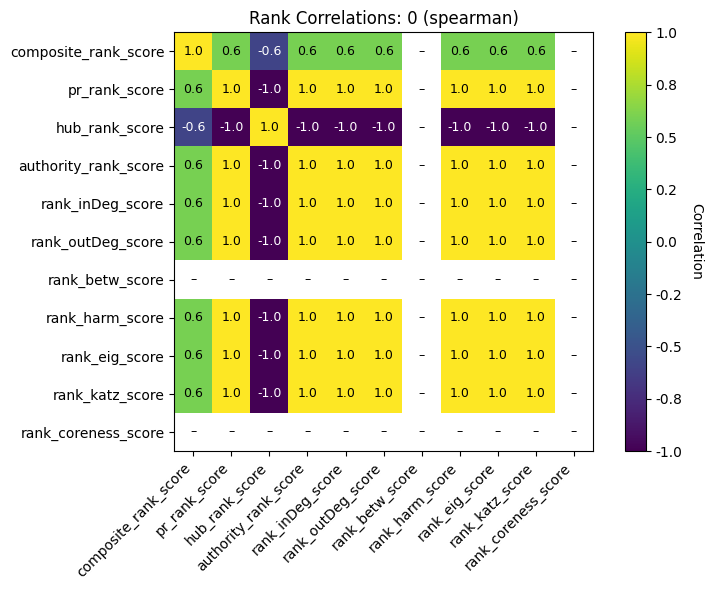

In [21]:
rank_cols = [
    'composite_rank','pr_rank','hub_rank','authority_rank',
    'rank_inDeg','rank_outDeg','rank_betw','rank_harm','rank_eig','rank_katz','rank_coreness'
]

spearman_corrs = build_comp.corr_matrices_per_group(
    df_all,
    method='spearman',
    rank_cols=rank_cols,
    min_nodes=5
)

gid = list(spearman_corrs.keys())[0]
mat = build_comp.plot_group_corr(
    df_all, gid=gid, method='spearman',
    rank_cols=[c for c in rank_cols if c in df_all.columns], min_nodes=5
)

Correlation at a global level (all subnetworks)

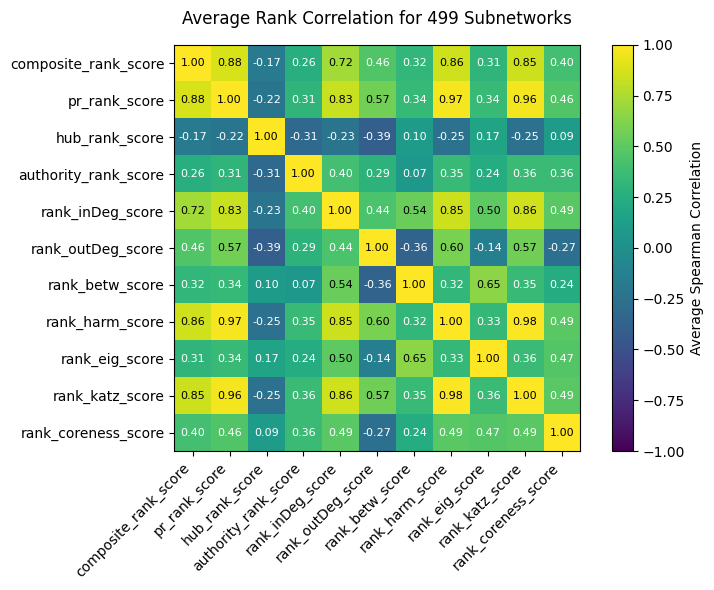

In [22]:
avg_mat, n_subnetworks = build_comp.average_corr_matrix(
    spearman_corrs,
    df_nw_summary=df_nw_summary,
    min_nodes=5
)

build_comp.plot_avg_corr(avg_mat, n_subnetworks)

Justification of Composite Calculation Weightings

In [23]:
# Compare different weights
weights = [
    # --- Baseline and balanced ---
    {"name": "equal",       "pr": 0.25, "val": 0.25, "in": 0.25, "out": 0.25},
    {"name": "balanced",    "pr": 0.50, "val": 0.40, "in": 0.07, "out": 0.03},  # mild bias toward PR/Val balance
    {"name": "current",     "pr": 0.60, "val": 0.30, "in": 0.07, "out": 0.03},  # your existing choice

    # --- PR-dominant variations ---
    {"name": "pr_heavy",    "pr": 0.70, "val": 0.20, "in": 0.07, "out": 0.03},  # strong structural focus
    {"name": "pr_extreme",  "pr": 0.80, "val": 0.15, "in": 0.03, "out": 0.02},  # almost pure influence
    {"name": "pr_mid",      "pr": 0.55, "val": 0.35, "in": 0.07, "out": 0.03},  # small step toward value

    # --- Value-dominant variations ---
    {"name": "val_heavy",   "pr": 0.20, "val": 0.70, "in": 0.06, "out": 0.04},  # strong value focus
    {"name": "val_mid",     "pr": 0.40, "val": 0.50, "in": 0.06, "out": 0.04},  # moderate value emphasis
    {"name": "val_extreme", "pr": 0.10, "val": 0.80, "in": 0.05, "out": 0.05},  # nearly pure monetary flow

    # --- Degree-emphasised variants (for testing structural noise) ---
    {"name": "deg_heavy",   "pr": 0.40, "val": 0.30, "in": 0.20, "out": 0.10},  # boosts degree importance
    {"name": "deg_equal",   "pr": 0.33, "val": 0.33, "in": 0.17, "out": 0.17},  # even split among all metrics
]

summary, details = build_comp.compare_weights_top_fraction(
          df_txn_features=df_all,
     df_pr=df_all[["node","pagerank"]],
     df_nw_txn_final=df_all[["merged_subnetwork_id","node"]].rename(columns={"node":"txn_id"}),
     nw_txn_col="txn_id",
     group_col="merged_subnetwork_id",
     weights_list=weights,
     top_frac=0.20,
     min_nodes=5,
     return_details=True
 )


→ Evaluating weights: equal
→ Evaluating weights: balanced
→ Evaluating weights: current
→ Evaluating weights: pr_heavy
→ Evaluating weights: pr_extreme
→ Evaluating weights: pr_mid
→ Evaluating weights: val_heavy
→ Evaluating weights: val_mid
→ Evaluating weights: val_extreme
→ Evaluating weights: deg_heavy
→ Evaluating weights: deg_equal


In [24]:
summary

,weight_set,median_BTC_share,median_PR_percentile,n_subnetworks,top_frac
0,pr_heavy,0.2930,92.3077,499,0.2000
1,pr_extreme,0.2805,92.3077,499,0.2000
2,current,0.3205,91.6667,499,0.2000
3,pr_mid,0.3244,91.6667,499,0.2000
4,deg_heavy,0.3319,91.1765,499,0.2000
5,balanced,0.3497,91.1111,499,0.2000
6,equal,0.3243,90.7143,499,0.2000
7,deg_equal,0.3579,90.6250,499,0.2000
8,val_mid,0.4350,80.0000,499,0.2000
9,val_heavy,0.5109,56.2500,499,0.2000


In [25]:
details["current"].head()

,subnet,btc_share,pr_percentile_med,n_nodes,k_selected
0,0,0.8862,75.0000,8,2
1,10018,0.3107,91.6667,12,3
2,10026,0.2588,91.6667,18,4
3,10067,0.1625,95.0000,10,2
4,10073,0.3086,92.8571,7,2


--------------
##### Export Ranking Tables to BigQuery
--------------


In [ ]:
# Define your project ID
#project_id = 'extreme-torch-467913-m6'
#to_gbq(dataframe = df_all, destination_table = 'networks.network_txn_rank', project_id=project_id, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 11037.64it/s]
